<a href="https://colab.research.google.com/github/vhmartinsp/MyRepository/blob/main/Transfer_Learning_cat_dogs_DIO_Victor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import zipfile
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



#1.Baixando e organizando dados

In [2]:
# 1. Baixando os arquivos ZIP do GitHub
!wget https://github.com/vhmartinsp/cats_dogs_dataset_dogs/archive/refs/heads/main.zip -O dogs.zip
!wget https://github.com/vhmartinsp/cats_dogs_dataset_cats/archive/refs/heads/main.zip -O cats.zip


--2025-01-12 18:23:22--  https://github.com/vhmartinsp/cats_dogs_dataset_dogs/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/vhmartinsp/cats_dogs_dataset_dogs/zip/refs/heads/main [following]
--2025-01-12 18:23:22--  https://codeload.github.com/vhmartinsp/cats_dogs_dataset_dogs/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘dogs.zip’

dogs.zip                [    <=>             ]  13.26M  14.6MB/s    in 0.9s    

2025-01-12 18:23:24 (14.6 MB/s) - ‘dogs.zip’ saved [13904028]

--2025-01-12 18:23:24--  https://github.com/vhmartinsp/cats_dogs_dataset_cats/archive/refs/heads/main.zip

### 1.2. Extraindo os arquivos ZIP


In [3]:
# 2. Extraindo os arquivos ZIP por meio da função extract zip
def extract_zip(file_name, extract_to):
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

extract_zip("dogs.zip", "/content/dogs")
extract_zip("cats.zip", "/content/cats")


# 2.Divisão dos dados entre treino, validação e teste



In [4]:
#Criando os diretórios
base_dir = "/content/dataset"
os.makedirs(base_dir, exist_ok=True)

dog_dir = "/content/dogs/cats_dogs_dataset_dogs-main"
cat_dir = "/content/cats/cats_dogs_dataset_cats-main"

train_dir = os.path.join(base_dir, "train")
os.makedirs(train_dir, exist_ok=True)

train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")

os.makedirs(train_cats_dir, exist_ok=True)
os.makedirs(train_dogs_dir, exist_ok=True)

In [5]:
# Movendo imagens de gatos e cachorros para diretórios específicos
for img in os.listdir(dog_dir):
    shutil.move(os.path.join(dog_dir, img), train_dogs_dir)

for img in os.listdir(cat_dir):
    shutil.move(os.path.join(cat_dir, img), train_cats_dir)

print("Organização concluída!")

Organização concluída!


In [6]:
cats_images = os.listdir(train_cats_dir)
dogs_images = os.listdir(train_dogs_dir)


In [7]:
# Dividindo os dados em treino, validação e teste
train_cats, test_cats = train_test_split(cats_images, test_size=0.2, random_state=42)
train_dogs, test_dogs = train_test_split(dogs_images, test_size=0.2, random_state=42)

In [8]:
# Definindo os diretórios para os conjuntos de treino, validação e teste
test_dir = os.path.join(base_dir, "test")
os.makedirs(test_dir, exist_ok=True)

test_cats_dir = os.path.join(test_dir, "cats")
test_dogs_dir = os.path.join(test_dir, "dogs")

In [9]:
os.makedirs(test_cats_dir, exist_ok=True)
os.makedirs(test_dogs_dir, exist_ok=True)

In [10]:
# Mover as imagens de teste para seus respectivos diretórios
for img in test_cats:
    shutil.move(os.path.join(train_cats_dir, img), test_cats_dir)

for img in test_dogs:
    shutil.move(os.path.join(train_dogs_dir, img), test_dogs_dir)

In [11]:

# Organizando as imagens de treino e validação
train_cats, val_cats = train_test_split(train_cats, test_size=0.2, random_state=42)
train_dogs, val_dogs = train_test_split(train_dogs, test_size=0.2, random_state=42)

In [12]:
# Movendo as imagens para as pastas correspondentes
validation_cats_dir = os.path.join(base_dir, "validation/cats")
validation_dogs_dir = os.path.join(base_dir, "validation/dogs")

In [13]:
os.makedirs(validation_cats_dir, exist_ok=True)
os.makedirs(validation_dogs_dir, exist_ok=True)

In [14]:
for img in val_cats:
    shutil.move(os.path.join(train_cats_dir, img), validation_cats_dir)

for img in val_dogs:
    shutil.move(os.path.join(train_dogs_dir, img), validation_dogs_dir)

print("Divisão entre treino, validação e teste concluída!")

Divisão entre treino, validação e teste concluída!


# 3.Pré Processamento de dados

In [15]:
batch_size = 32
img_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Separação em treinamento e validação
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 410 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


# 4.Carregando o modelo VGG16 pré-treinado

In [19]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #include_top remove a última camada

Congelarei os pesos do modelo base, uma vez que estou forçando ele a aprender apenas nas camadas novas

In [20]:
# Congelando os pesos do modelo base
for layer in base_model.layers:
    layer.trainable = False

Dado que estou usando um modelo pré-treinado, personalizarei as camadas para que atendam as necessidades do objetivo binário do transfer-learning

In [21]:
# Adicionando camadas personalizadas
x = base_model.output # Captura a saída do modelo base para ser usada como entrada para as camadas seguintes que vou adicionar
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x) # transforma a saída do neurônio para um valor entre 0 e 1, valores próximos a 0 é uma classe e mais próximos de 1 outra classe

model = Model(inputs=base_model.input, outputs=predictions)


Compilando o modelo

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# 5.Treinamento do modelo

In [23]:
# 8. Treinamento do modelo
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5419 - loss: 0.7144 - val_accuracy: 0.8646 - val_loss: 0.5736
Epoch 2/20
 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5625 - loss: 0.6964

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - accuracy: 0.5625 - loss: 0.6964 - val_accuracy: 1.0000 - val_loss: 0.4624
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.7092 - loss: 0.5896 - val_accuracy: 0.8438 - val_loss: 0.4989
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6875 - loss: 0.5549 - val_accuracy: 0.8333 - val_loss: 0.4727
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.7029 - loss: 0.5632 - val_accuracy: 0.8542 - val_loss: 0.4432
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7812 - loss: 0.4806 - val_accuracy: 0.8333 - val_loss: 0.4366
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.8046 - loss: 0.4519 - val_accuracy: 0.9375 - val_loss: 0.3796
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8462 - loss: 0.4421 - val_accuracy: 0.8333 - val_loss: 0.4589
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.8298 - loss: 0.4093 - val_accuracy: 0.9375 - val_loss:

# Avaliação do modelo

In [31]:
# 9. Avaliação do modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [32]:
epochs_range = range(epochs)



Agora, usarei o matplolib para os gráficos de métricas de avaliação (acurácia e perda)

In [26]:
import numpy as np

# Garantindo que as listas tenham o mesmo tamanho
if len(acc) > len(val_acc):
    val_acc += [val_acc[-1]] * (len(acc) - len(val_acc))
elif len(val_acc) > len(acc):
    acc += [acc[-1]] * (len(val_acc) - len(acc))

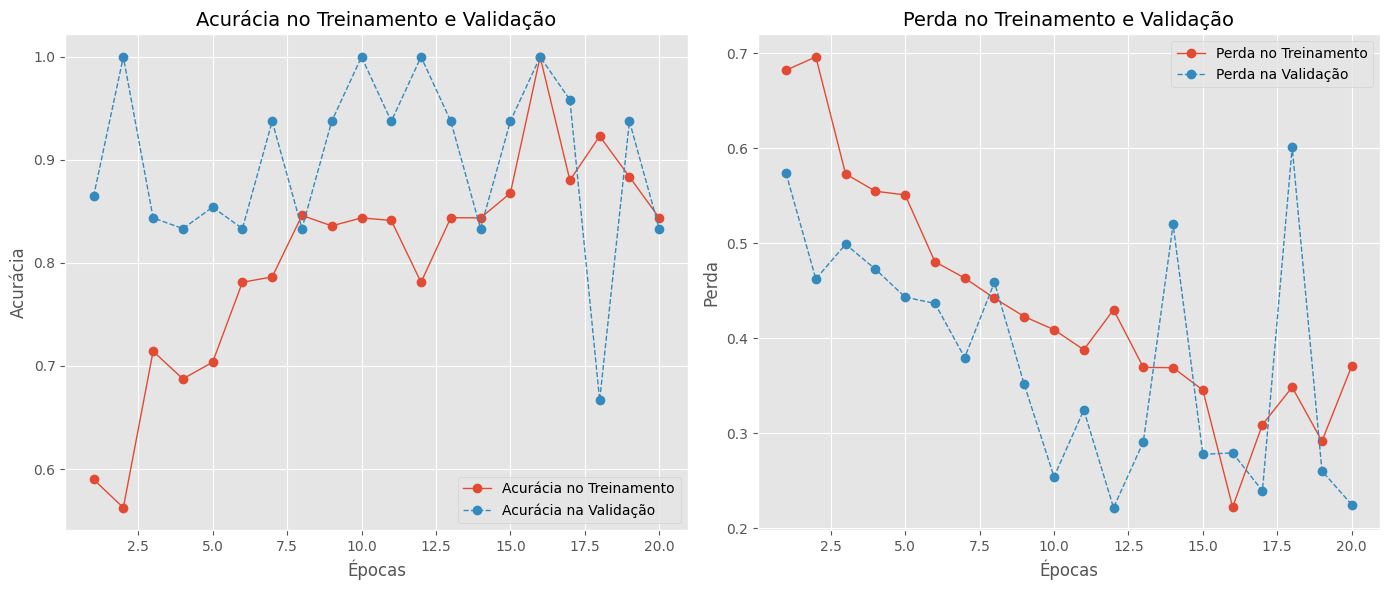

In [27]:
# Intervalo de épocas
epochs_range = range(1, len(acc) + 1)

# Configurando o estilo do gráfico
plt.style.use('ggplot')

# Criando a figura
plt.figure(figsize=(14, 6))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia no Treinamento', marker='o', linestyle='-', linewidth=1)
plt.plot(epochs_range, val_acc, label='Acurácia na Validação', marker='o', linestyle='--', linewidth=1)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.title('Acurácia no Treinamento e Validação', fontsize=14)
plt.legend(loc='lower right', fontsize=10)

# Gráfico de Perda
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda no Treinamento', marker='o', linestyle='-', linewidth=1)
plt.plot(epochs_range, val_loss, label='Perda na Validação', marker='o', linestyle='--', linewidth=1)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Perda', fontsize=12)
plt.title('Perda no Treinamento e Validação', fontsize=14)
plt.legend(loc='upper right', fontsize=10)

# Ajustando layout
plt.tight_layout()

# Exibindo o gráfico
plt.show()

# Avaliação no conjunto de teste

In [28]:

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Teste de Acurácia: {test_acc}")
print(f"Test de Perda: {test_loss}")


Found 160 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9069 - loss: 0.3269
Teste de Acurácia: 0.918749988079071
Test de Perda: 0.30445247888565063


Classificação de imagens

In [29]:
# Salvando o modelo
model.save('modelo_cats_vs_dogs.h5')


In [33]:
from tensorflow.keras.models import load_model

# Carregando o modelo salvo
model = load_model('modelo_cats_vs_dogs.h5')


Preparando a imagem no mesmo formato utilizado durante o treinamento

In [46]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Definindo o caminho da imagem a ser classificada
caminho_imagem = '/content/cat1.jpeg'

# Carregando a imagem e redimensionando
img = image.load_img(caminho_imagem, target_size=(224, 224))

# Convertendo a imagem para um array NumPy e escalando os valores
img_array = image.img_to_array(img) / 255.0

# Expandindo as dimensões para incluir o lote (batch)
img_array = np.expand_dims(img_array, axis=0)


In [47]:
# Fazendo a previsão
previsao = model.predict(img_array)

# Interpretando o resultado
if previsao[0] > 0.5:
    print("É um cachorro!")
else:
    print("É um gato!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
É um gato!
